In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.inspection import PartialDependenceDisplay
import shap
from itertools import product
from sqlalchemy import create_engine

In [41]:
engine = create_engine('sqlite:///nba_stats.db')
nba_player_seasons_complete = pd.read_sql("SELECT * FROM nba_player_seasons_complete", con=engine)
print(nba_player_seasons_complete.shape)
nba_player_seasons_complete.head()

(18178, 32)


,Rk,Player,Age,Team,Pos,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Awards,Year
0,4,Julius Erving,29,PHI,SF,78,78,36.1,10.7,20.7,...,4.6,7.4,4.6,2.2,1.8,3.6,2.7,26.9,"MVP-2,AS,NBA1",1980
1,17,Larry Bird,23,BOS,PF,82,82,36.0,8.5,17.8,...,7.8,10.4,4.5,1.7,0.6,3.2,3.4,21.3,"MVP-4,ROY-1,AS,NBA1",1980
2,47,Cedric Maxwell,24,BOS,SF,80,80,34.3,5.7,9.4,...,5.3,8.8,2.5,1.0,0.8,2.9,3.3,16.9,None,1980
3,63,Darryl Dawkins,23,PHI,C,80,80,31.8,6.2,11.8,...,6.2,8.7,1.9,0.6,1.8,2.9,4.1,14.7,None,1980
4,67,Dave Cowens,31,BOS,C,66,55,32.7,6.4,14.1,...,6.2,8.1,3.1,1.0,0.9,1.6,3.3,14.2,AS,1980


## Prediction Workflow

### 1. Data Splitting
First, we identify our target variable (`Age`) and potential features,
then split our data into training and testing sets to avoid data leakage and ensure that our model evaluations are realistic.

### 2. Feature Engineering & Selection
Ffeature engineering steps might include:
- Creating interaction terms (e.g. FG% × FGA).
- Log transformations for skewed features.
- Domain-specific metrics (e.g. usage rate, advanced stats).

### 3. Model Exploration & Selection
We will experiment with three models:
1. **Linear Regression**
2. **Lasso Regression** (for regularization and feature selection)
3. **Random Forest Regression** (an ensemble method often capturing nonlinearities better)

For now, let’s move directly to modeling and see how well our selected features predict `Age`.

In [50]:
# Define target and features
target = 'Age'
features = [
    'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
    '3P', '3PA', '3P%', '2P', '2PA', '2P%',
    'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
    'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
    'PTS', 'Year'
]

# Split the data
X = nba_player_seasons_complete[features]
Y = nba_player_seasons_complete[target]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=541)

In [51]:
# ---------------------
# Linear Regression
# ---------------------

kf = KFold(n_splits=5, shuffle=True)
linreg_model = LinearRegression()

mse_linreg, mae_linreg, r2_linreg = [], [], []

# Cross-validation loop
for train_index, test_index in kf.split(X_train):
    split_X_train, split_X_test = X_train.iloc[train_index], X_train.iloc[test_index]
    split_Y_train, split_Y_test = Y_train.iloc[train_index], Y_train.iloc[test_index]

    linreg_model.fit(split_X_train, split_Y_train)
    Y_pred_linreg = linreg_model.predict(split_X_test)

    mse_linreg.append(mean_squared_error(split_Y_test, Y_pred_linreg))
    mae_linreg.append(mean_absolute_error(split_Y_test, Y_pred_linreg))
    r2_linreg.append(r2_score(split_Y_test, Y_pred_linreg))

print(f"Linear Regression\n"
      f"MSE: {np.mean(mse_linreg):.3f}, "
      f"MAE: {np.mean(mae_linreg):.3f}, "
      f"R²: {np.mean(r2_linreg):.3f}")

linreg_df = pd.DataFrame({
    "feature_name": features,
    "coefficient" : linreg_model.coef_
})
linreg_df.head()

Linear Regression
MSE: 15.387, MAE: 3.163, R²: 0.087


,feature_name,coefficient
0,G,-0.006702
1,GS,-0.009541
2,MP,0.185931
3,FG,-1.008004
4,FGA,-0.094880


**Observation**: The linear regression explains roughly 8-10% of the variance (R-Squared: 0.08—0.10). This is not very high, suggesting that a simple linear approach may not capture the complexity of how these features relate to age.

Next, we try Lasso Regression, which can shrink coefficients and help with feature selection.


In [52]:
# ---------------------
# Lasso Regression
# ---------------------

# Find an optimal alpha using cross-validation
lassocv_model = LassoCV(cv=5, max_iter=100_000)
lassocv_model.fit(X_train, Y_train)

best_alpha = lassocv_model.alpha_
print(f"Best Alpha Value: {best_alpha:.4f}")

# Create a Lasso model with the best alpha and scaled features
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso_model', Lasso(alpha=best_alpha, max_iter=100_000))
])

mse_lasso, mae_lasso, r2_lasso = [], [], []

for train_index, test_index in kf.split(X_train):
    split_X_train, split_X_test = X_train.iloc[train_index], X_train.iloc[test_index]
    split_Y_train, split_Y_test = Y_train.iloc[train_index], Y_train.iloc[test_index]

    pipe.fit(split_X_train, split_Y_train)
    Y_pred_lasso = pipe.predict(split_X_test)

    mse_lasso.append(mean_squared_error(split_Y_test, Y_pred_lasso))
    mae_lasso.append(mean_absolute_error(split_Y_test, Y_pred_lasso))
    r2_lasso.append(r2_score(split_Y_test, Y_pred_lasso))

print(f"Lasso Regression\n"
      f"MSE: {np.mean(mse_lasso):.3f}, "
      f"MAE: {np.mean(mae_lasso):.3f}, "
      f"R²: {np.mean(r2_lasso):.3f}")

Best Alpha Value: 0.0071
Lasso Regression
MSE: 15.408, MAE: 3.169, R²: 0.086


**Observation**: Lasso shows comparable performance to Linear Regression, indicating modest explanatory power for `Age`.

Finally, we will try a Random Forest model, which often captures nonlinear relationships and interactions more effectively.

In [53]:
# --------------------------
# Random Forest Regression
# --------------------------

rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, Y_train)

preds = rf_reg.predict(X_test)
mse_rf = mean_squared_error(Y_test, preds)
mae_rf = mean_absolute_error(Y_test, preds)
r2_rf = r2_score(Y_test, preds)

print(f"Random Forest Regression\n"
      f"MSE: {mse_rf:.3f}, "
      f"MAE: {mae_rf:.3f}, "
      f"R²: {r2_rf:.3f}")

Random Forest Regression
MSE: 13.937, MAE: 3.012, R²: 0.198


**Observation**: The Random Forest outperforms the linear models, explaining roughly 19-20% of the variance in `Age`.
Although this is an improvement over linear models, the R-Squared values remain modest.
Age may be influenced by other factors not captured in our dataset or may simply not be highly predictable from standard game stats alone.

Next, let’s plot the feature importance.

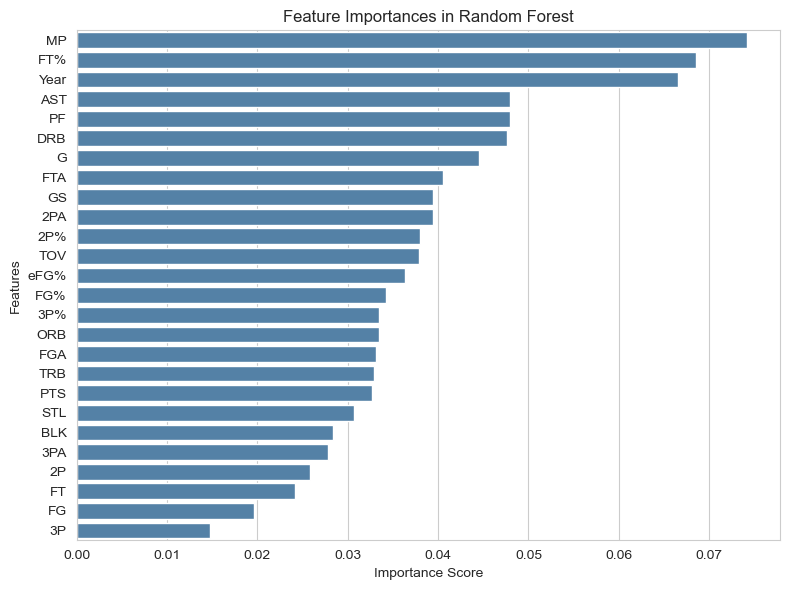

In [54]:
# Feature Importances
importances = rf_reg.feature_importances_
feature_names = X_train.columns
feat_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=feat_importances, y=feat_importances.index, color="steelblue")
plt.title("Feature Importances in Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

### Observations
- **Random Forest** shows the best performance (R² ≈ 0.19), but overall predictive power remains limited.
- **Feature Importance** highlight which predictors (e.g. `MP`, `FT%`, `Year`) most influence the model’s age predictions.

Next, we will use `GridSearchCV` or `RandomizedSearchCV` to find optimal parameters for the Random Forest.


In [57]:
param_grid_quick = {
    'n_estimators': [100, 200, 400],
    'max_depth': [30, 40, 50, 60],
    'min_samples_split': [2, 4, 8]
}

param_grid_slow = {
    'n_estimators': [100, 200, 400, 800],
    'max_depth': [30, 40, 50, 60, None],
    'min_samples_split': [2, 5, 10, 20, 40]
}

# Count all possible combinations
total_combinations_quick = len(list(product(*param_grid_quick.values())))
total_combinations_slow = len(list(product(*param_grid_slow.values())))

print('Total Combinations (Quick):', total_combinations_quick)
print('Total Combinations (Slow):', total_combinations_slow)

Total Combinations (Quick): 36
Total Combinations (Slow): 100


In [ ]:
# Using GridSearchCV (for thoroughness)
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=param_grid_quick,
    cv=2,
    scoring='r2',
    n_jobs=-1
)

grid_search.fit(X_train, Y_train)
print("Best parameters:", grid_search.best_params_)
print("Best score (R²):", grid_search.best_score_)

In [38]:
# Using RandomizedSearchCV (for speed)
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(),
    param_distributions=param_grid_quick,
    n_iter=10,
    cv=5,
    scoring='r2',
    n_jobs=-1,
)

random_search.fit(X_train, Y_train)
print("Best parameters:", random_search.best_params_)
print("Best score (R²):", np.round(random_search.best_score_, 3))

Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': 25}
Best score (R²): 0.177


Using what we learn from `GridSearchCV` or `RandomizedSearchCV`,
re-run the Random Forests model on the test set.

In [55]:
best_rf = RandomForestRegressor(
    n_estimators=200,
    min_samples_split=5,
    max_depth=25
)
best_rf.fit(X_train, Y_train)

final_preds = best_rf.predict(X_test)
final_r2 = r2_score(Y_test, final_preds)
print(f"Final Test Set R²: {final_r2:.3f}")

Final Test Set R²: 0.201


**Observation**: This Random Forest model explains roughly the same amount of the variance in `Age`, even with the updated hyperparameters.

Now, let’s experiment with gradient boosting methods such as `XGBoost` to see if we can improve our R-Squared value.

In [63]:
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    eval_metric="rmse",
    tree_method="hist",
    early_stopping_rounds=10,
    n_jobs=-1
)

xgb_model.fit(
    X_train, Y_train,
    eval_set=[(X_test, Y_test)],
    verbose=False
)

y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost R²:", np.round(r2_score(Y_test, y_pred_xgb), 3))

XGBoost R²: 0.204


**Observation**: Similarly, using XGBoost explains roughly the same amount of the variance in `Age` as the other best approaches.

Next, we will investigate partial dependence plots and SHAP values to see how each feature influences predicted `Age`.

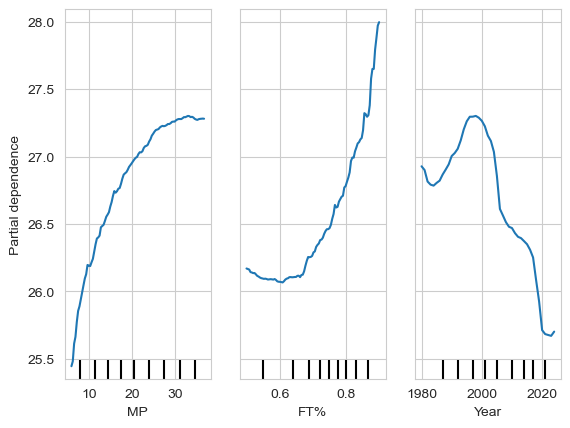

In [66]:
# Partial dependence plots
PartialDependenceDisplay.from_estimator(
    estimator=best_rf,  # or xgb_model
    X=X_train,
    features=['MP', 'FT%', 'Year'],
    kind='average'
)
plt.show()

**Observations:**
- `MP`: As minutes per game increases, the partial dependence plot shows a tendency for the model to predict higher ages. This may reflect that older players who remain in the league often play significant minutes.
- `FT%`: The relationship is quite upward, suggesting that older players may have somewhat higher free-throw percentages (or that better free-throw shooters last longer in the league).
- `Year`: The model captures some historical trend in the data. There appears to be a peak around certain eras, indicating that in specific years, players in the data might be older, on average.

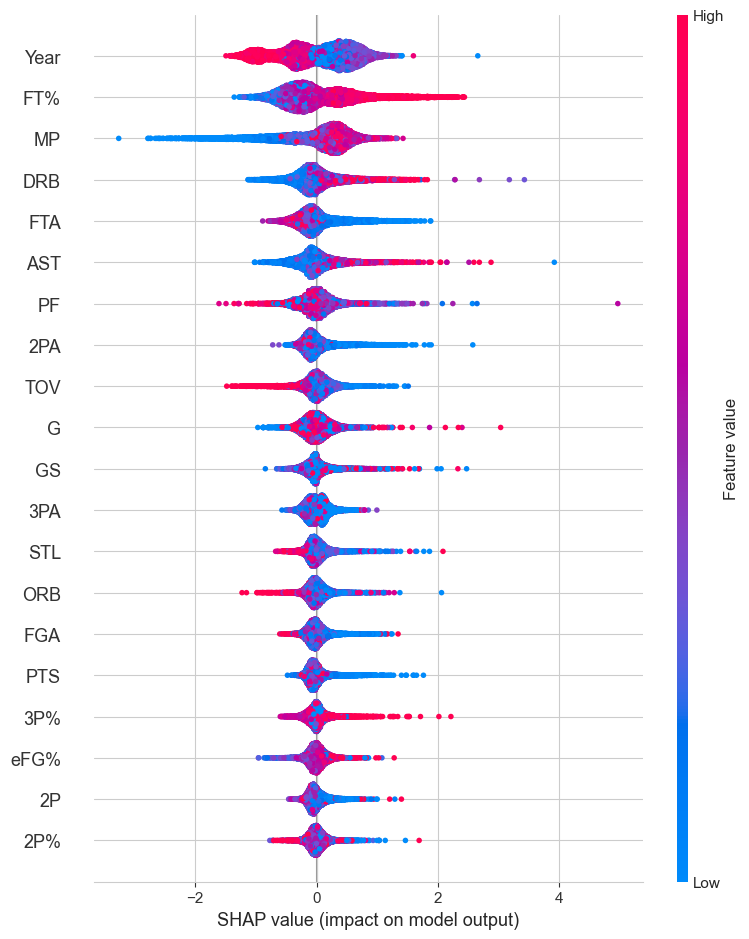

In [68]:
# SHAP values
explainer = shap.TreeExplainer(best_rf)  # or xgb_model
shap_values = explainer.shap_values(X_train, approximate=True)
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)

**Observations**:
- **Overall Feature Influence**: The SHAP summary plot suggests that `Year`, `FT%`, and `MP` have the highest impact on predicting a player’s age.
- **Color**: Red points indicate higher feature values, while blue points indicate lower values. For example, red points for `MP` (i.e. high minutes played) typically push age predictions higher.
- **Spread**: The vertical dispersion within each feature indicates variance in how that feature affects age predictions across different players.

## Conclusion

Even after hyperparameter tuning and experimenting with XGBoost, our best models explain only ~20% of the variance in Age.
This suggests
that standard box-score statistics alone may not fully capture the factors
determining a player’s age
(career length, health history, personal choices, non-basketball factors, etc.).

Partial Dependence and SHAP analyses confirm that a handful of metrics drive most of the model’s predictions, but their combined predictive power is still modest.

To improve results, we could:
- Engineer additional features (usage rate, PER, etc.) that may correlate more strongly with a player’s career stage.
- Collect more nuanced data (injuries, contract details, position-specific roles) to better explain why some players continue playing at older ages.
- Explore advanced modeling (neural networks, more sophisticated ensemble methods).

While we can achieve modest performance in predicting age from basic performance metrics,
the low R-Squared values indicate that age is influenced by a range of factors not fully captured by these statistics.